In [0]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [0]:
protoFile = "/content/drive/My Drive/Rohit Jain - SOP/Our architecture/coco.prototxt"
weightsFile = "/content/drive/My Drive/Rohit Jain - SOP/Our architecture/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [0]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    res = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = res[0]
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [0]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

    

In [0]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [0]:
image1 = cv2.imread("/content/drive/My Drive/Rohit Jain - SOP/Coco Dataset/000000001000.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [13]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 18.906973600387573


(-0.5, 639.5, 479.5, -0.5)

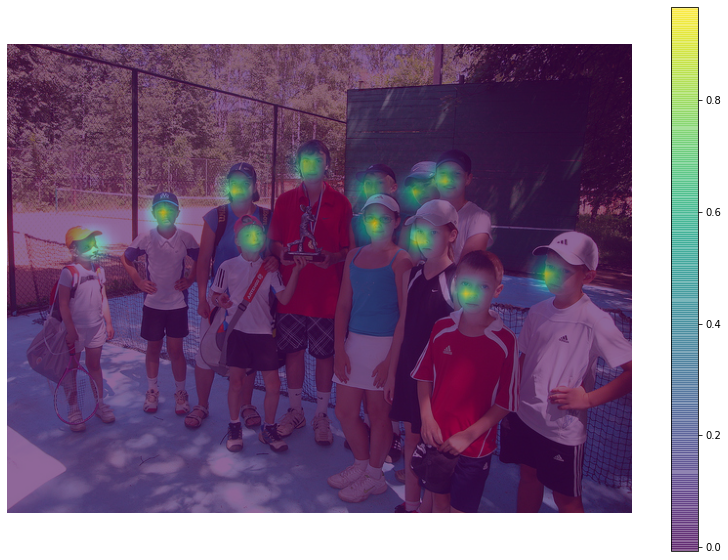

In [14]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [15]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(470, 255, 0.9104969), (552, 235, 0.8778922), (87, 204, 0.7350136), (419, 202, 0.8361974), (252, 202, 0.8028446), (160, 172, 0.9303448), (376, 182, 0.9671498), (232, 150, 0.872315), (448, 140, 0.8618814), (305, 121, 0.7856921)]
Keypoints - Neck : [(470, 297, 0.84426534), (563, 276, 0.80455506), (438, 235, 0.79142725), (77, 234, 0.8933114), (242, 224, 0.9219754), (376, 222, 0.8627734), (160, 202, 0.7682861), (377, 172, 0.25835124), (448, 181, 0.66733295), (233, 181, 0.7209182), (305, 161, 0.83971244)]
Keypoints - R-Sho : [(439, 296, 0.7677648), (533, 276, 0.7646464), (417, 234, 0.847948), (65, 234, 0.806224), (222, 224, 0.94591045), (139, 202, 0.82388365), (408, 182, 0.692976), (211, 181, 0.8320582), (354, 214, 0.7296687), (283, 161, 0.8448915)]
Keypoints - R-Elb : [(418, 338, 0.726777), (511, 328, 0.46310186), (56, 266, 0.9054292), (344, 266, 0.77407736), (408, 215, 0.14454949), (200, 223, 0.83281237), (118, 215, 0.76374876), (273, 204, 0.79356444)]
Keypoints - R-Wr

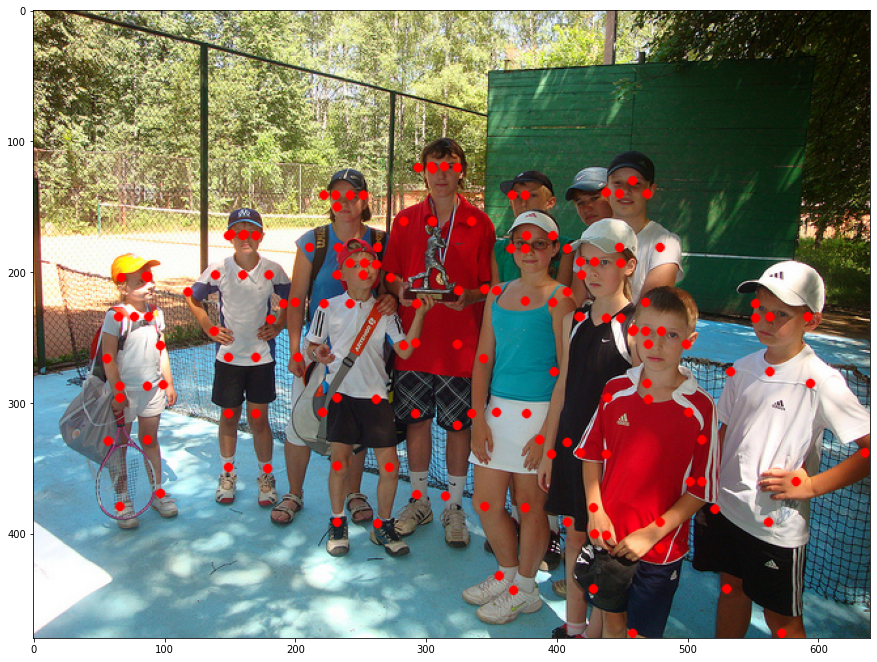

In [16]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [17]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[10.        , 21.        ,  1.01916812],
       [11.        , 22.        ,  0.98913817],
       [12.        , 23.        ,  0.91701424],
       [13.        , 24.        ,  0.976906  ],
       [14.        , 25.        ,  1.0607782 ],
       [15.        , 29.        ,  0.83936959],
       [16.        , 26.        ,  0.96481665],
       [18.        , 27.        ,  0.86374577],
       [19.        , 28.        ,  1.01753113],
       [20.        , 30.        ,  0.97739877]]), array([[10.        , 47.        ,  0.94678063],
       [11.        , 48.        ,  0.90336219],
       [12.        , 49.        ,  0.79664134],
       [13.        , 50.        ,  0.98842465],
       [15.        , 51.        ,  0.92857196],
       [16.        , 52.        ,  0.95167057],
       [17.        , 54.        ,  0.40128267],
       [18.        , 54.        ,  0.87588624],
       [19.        , 55.        ,  0.95406223],
       [20.        , 56.        ,  0.99644686]]), array([[21.        , 31.        ,  

In [0]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

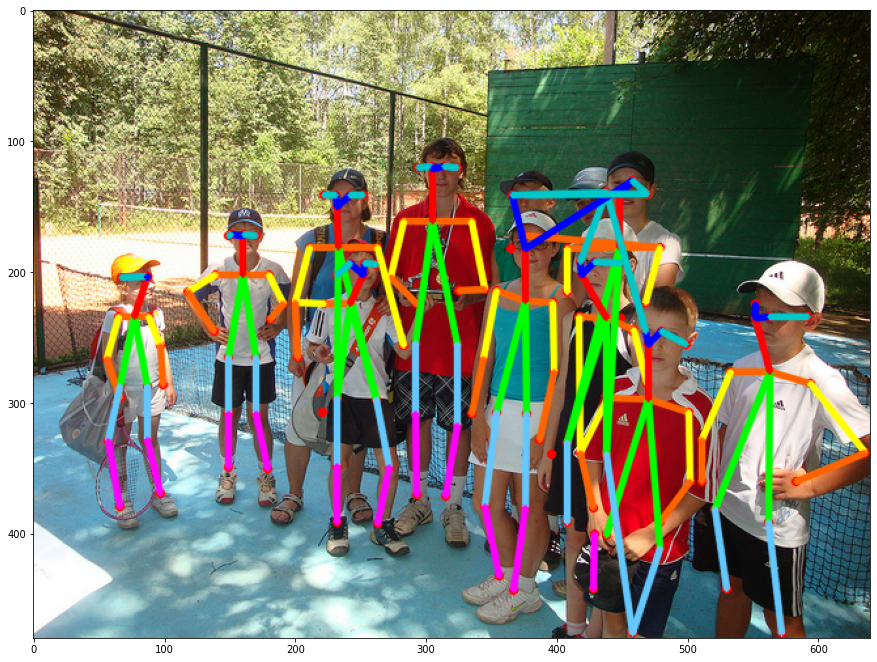

In [19]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

VIDEOOOOOOOOOOOOOOOOOOOOOOO

In [0]:
cap = cv2.VideoCapture("/content/drive/My Drive/Rohit Jain - SOP/Implementation of Faster R-CNN on custom Dataset/VIRAT_S_010204_05_000856_000890.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('"/content/drive/My Drive/Rohit Jain - SOP/pafoutput.avi',fourcc, 20.0, (640,480))
counting = 30
while(counting<50):
    ret, frame = cap.read()
    image1 = frame
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]
    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    print("Time Taken = {}".format(time.time() - t))
    i = 0
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
    #     plt.figure()
    #     plt.imshow(255*np.uint8(probMap>threshold))
        keypoints = getKeypoints(probMap, threshold)
        #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)

    frameClone = image1.copy()
    for i in range(nPoints):
        for j in range(len(detected_keypoints[i])):
            cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
    plt.figure(figsize=[15,15])
    plt.imshow(frameClone[:,:,[2,1,0]])
    valid_pairs, invalid_pairs = getValidPairs(output)
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)
    for i in range(17):
        for n in range(len(personwiseKeypoints)):
            index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
            if -1 in index:
                continue
            B = np.int32(keypoints_list[index.astype(int), 0])
            A = np.int32(keypoints_list[index.astype(int), 1])
            cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
            
    plt.figure(figsize=[15,15])
    out.write(frameClone[:,:,[2,1,0]])

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

Time Taken = 12.142197847366333
[array([[2.        , 7.        , 1.00641039],
       [3.        , 8.        , 0.93284448],
       [4.        , 8.        , 0.4928233 ],
       [5.        , 9.        , 0.81248695]]), array([[ 2.        , 19.        ,  0.97597999],
       [ 3.        , 18.        ,  0.87092876],
       [ 5.        , 20.        ,  0.79417938]]), array([[ 7.        , 11.        ,  0.80539661]]), array([[11.        , 15.        ,  0.75363137],
       [13.        , 17.        ,  0.1257619 ]]), array([[18.        , 22.        ,  0.89064798],
       [20.        , 21.        ,  0.82303234]]), array([[21.        , 24.        ,  0.62364162],
       [22.        , 23.        ,  0.49446906]]), array([[ 2.        , 26.        ,  0.75461365],
       [ 3.        , 28.        ,  0.9122391 ],
       [ 4.        , 28.        ,  0.33398406],
       [ 5.        , 27.        ,  0.94306476]]), array([[26.        , 30.        ,  0.90386235],
       [27.        , 32.        ,  0.88183211],
     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[array([[4.        , 7.        , 0.85932109],
       [5.        , 8.        , 0.82129345]]), array([[ 3.        , 16.        ,  0.64550996],
       [ 4.        , 17.        ,  0.88140208],
       [ 5.        , 18.        ,  0.29843136]]), array([[ 7.        , 11.        ,  0.59288793],
       [ 8.        , 12.        ,  0.17650122],
       [ 9.        , 13.        ,  0.15409297]]), array([[11.        , 14.        ,  0.26355627]]), array([[16.        , 21.        ,  0.75818449],
       [17.        , 22.        ,  0.72141875],
       [18.        , 23.        ,  0.72497569]]), array([[20.        , 24.        ,  0.19702177],
       [21.        , 25.        ,  0.28225027],
       [23.        , 26.        ,  0.65749983]]), array([[ 3.        , 28.        ,  0.95014295],
       [ 4.        , 29.        ,  0.82733873],
       [ 5.        , 30.        ,  0.82986877],
       [ 6.        , 31.        ,  0.22905294]]), array([[28.        , 33.        ,  0.77566609],
       [29.        , 32.       

In [0]:
cap.release()
out.release()
cv2.destroyAllWindows()